In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch
import torch.nn.functional as F

In [2]:
# Data Pre-processing

BitCoin = pd.read_csv('1_Bitcoin.csv')
BitCoin=BitCoin.applymap(lambda x: x.replace('$',''))
BitCoin=BitCoin.applymap(lambda x: x.replace(',',''))
cl = ['Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']
for c in cl:
    BitCoin[c] = BitCoin[c].astype(float)
MarketData = pd.read_excel('MarketData.xlsx') 
BitCoin['SP500'] = MarketData['S&P_processed'].values
BitCoin = BitCoin[:1485]

BitCoin = BitCoin.rename(columns={'Open*': 'Open', 'Close**': 'Close'})
data_l = len(BitCoin)
BitCoin = BitCoin[data_l::-1]

In [3]:
BitCoin.head(5)

,Date,Open,High,Low,Close,Volume,Market Cap,SP500
1484,Oct 06 2017,4324.46,4413.27,4320.53,4370.81,1.069940e+09,7.258926e+10,2477.13
1483,Oct 07 2017,4369.35,4443.88,4321.05,4426.89,9.069280e+08,7.352931e+10,2469.91
1482,Oct 08 2017,4429.67,4624.14,4405.64,4610.48,1.313870e+09,7.658929e+10,2472.54
1481,Oct 09 2017,4614.52,4878.71,4564.25,4772.02,1.968740e+09,7.928216e+10,2472.54
1480,Oct 10 2017,4776.21,4922.17,4765.10,4781.99,1.597140e+09,7.945760e+10,2472.54


In [4]:
BitCoin.tail()

,Date,Open,High,Low,Close,Volume,Market Cap,SP500
4,Oct 25 2021,60893.93,63729.33,60691.80,63039.83,3.106491e+10,1.188575e+12,1631.89
3,Oct 26 2021,63032.76,63229.03,59991.16,60363.79,3.487897e+10,1.138178e+12,1631.89
2,Oct 27 2021,60352.00,61435.18,58208.19,58482.39,4.365708e+10,1.102758e+12,1615.41
1,Oct 28 2021,58470.73,62128.63,58206.92,60622.14,4.525708e+10,1.143166e+12,1615.41
0,Oct 29 2021,60624.87,62927.61,60329.97,62227.96,3.685688e+10,1.173512e+12,1614.08


In [5]:
BitCoin.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap',
       'SP500'],
      dtype='object')

In [7]:
# Data = BitCoin[['Close','Open','High', 'Low', 'Volume','SP500']]
Data = BitCoin[['Close','Open','High', 'Low', 'Volume']]
in_dim = len(Data.columns)
# Time series length
time_stamp = 5

# Seperate training, validating, testing dataset
P = BitCoin[['Close','High', 'Low', 'Volume']]
split_1 = int(len(Data) * 0.6)
split_2 = int(len(Data) *0.8)

train = Data[0:split_1+time_stamp]
valid = Data[split_1:split_2 ]
test = Data[split_2-time_stamp :]


In [8]:
# Normalization

scaler = MinMaxScaler()

def data_processing(data, time_stamp):
    min_ = data['Close'].min()
    max_ = data['Close'].max()
    scaled_data = scaler.fit_transform(data)
    x, y = [], []
    for i in range(time_stamp, len(data)-time_stamp):
        x.append(scaled_data[i-time_stamp:i,:])
        y.append(scaled_data[i,0])
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], in_dim))
    print(x.shape)
    print(y.shape)
    return x,y,max_,min_

x_train, y_train, max_train, min_train = data_processing(train, time_stamp)
x_valid, y_valid,max_valid, min_valid  = data_processing(valid, time_stamp)
x_test, y_test,max_test, min_test   = data_processing(test, time_stamp)

(886, 5, 5)
(886,)
(287, 5, 5)
(287,)
(292, 5, 5)
(292,)


In [9]:
# Build function to make dataset for pytorch
class PriceDataset(Dataset):
    def __init__(self,x_train,y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    def __len__(self):
        return len(x_train)
    
    def __getitem__(self, index):
        return x_train[index], y_train[index]

def makeloader(dataset,batch_size):
    
    loader = DataLoader(dataset, batch_size, shuffle = True)
    return loader

In [10]:
# Make dataset
batch_size = 64

dataset =  PriceDataset(x_train, y_train)
loader = makeloader(dataset, batch_size)

val_dataset =  PriceDataset(x_valid, y_valid)
val_loader = makeloader(val_dataset, batch_size)

test_dataset =  PriceDataset(x_test, y_test)
test_loader = makeloader(test_dataset, batch_size)


# TESTING
for batch_x, batch_y in loader:
    print(batch_x[0][0])
    print(batch_y.shape)
    break
    
dataset.x_train.shape

tensor([0.1878, 0.1880, 0.1837, 0.1957, 0.0297], dtype=torch.float64)
torch.Size([64])


(886, 5, 5)

In [11]:
# Building the Hybrid model
class HybridBit(nn.Module):

    def __init__(self, input_dim,hidden_dim,out_dim):
        super(HybridBit, self).__init__()
        self.hidden_dim = hidden_dim
        
        #  Build the first layer of  CONV1D
        self.cov_1 = nn.Conv1d(input_dim,64,1)
        #  Build the inception layers
        #  The inception layer is consist of 3 CONV1D layer with kernel size 1, 3, 5 
        #   hoping to capture different patterns in different time intervals
        self.incept_1 = nn.Conv1d(64, 64, 1)
        self.incept_3 = nn.Conv1d(64, 64, 3)
        self.incept_5= nn.Conv1d(64, 64, 5)
        # Building the LSTM model with 3 layers all consisted of hidden dim of 64 dim
        self.lstm1 = nn.LSTM(64, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim)
        self.lstm4 = nn.LSTM(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(64,448) # FC
        self.fc2 = nn.Linear(448,32) # FC
        self.fc3 = nn.Linear(32, 16) # FC
        self.fc4 = nn.Linear(16, 1) # FC
        
    def forward(self, x_train):
        #       CONV1D  
        conv_1 = F.relu(self.cov_1(x_train.permute(0,2,1)))
        #       INCEPTION Layer (GOOGLENET)
        incept_1 = F.relu(self.incept_1(conv_1))
        incept_3 = F.relu(self.incept_3(conv_1))
        incept_5 = F.relu(self.incept_5(conv_1))
        cat = torch.cat((conv_1,incept_1, incept_3, incept_5), 2)
        lstm_out1, _ = self.lstm1(cat.permute(0,2,1))
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out3, _ = self.lstm3(lstm_out2)
        lstm_out,_ = self.lstm4(lstm_out3)
        fc_out1 =  self.fc1(lstm_out)
        fc_out2=  self.fc2(fc_out1)
        fc_out3 =  self.fc3(fc_out2)
        out =  self.fc4(fc_out3 )
        return out

In [12]:
model=HybridBit(in_dim,64,1)
print(model)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.5e-5)

HybridBit(
  (cov_1): Conv1d(5, 64, kernel_size=(1,), stride=(1,))
  (incept_1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (incept_3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (incept_5): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (lstm1): LSTM(64, 64)
  (lstm2): LSTM(64, 64)
  (lstm3): LSTM(64, 64)
  (lstm4): LSTM(64, 64)
  (fc1): Linear(in_features=64, out_features=448, bias=True)
  (fc2): Linear(in_features=448, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)


In [13]:
epoch = 400

# Initialize 2 lists for storing MAPE loss
Train_MAPE_list = np.zeros(epoch)
Valid_MAPE_list = np.zeros(epoch)

for epoch in range(epoch):     
       #     ====== TRAIN  ====== #
    model.train()
    total_loss = []
    for batch_x, batch_y in loader:
        model.zero_grad() # Clear them out Pytorch accumulated gradients before each instance
        out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1) # Run forward pass.
        loss =abs (((out - batch_y.float())*(max_train - min_train))/(batch_y.float()*(max_train - min_train)+min_train))
        loss = torch.mean(loss)
        loss.backward()
        optimizer.step()
        total_loss.append(loss)
    Train_MAPE = sum(total_loss)/len(total_loss)

    #     ====== VALID  ====== 
    model.eval()
    total_loss = []
    for batch_x, batch_y in val_loader:
            model.zero_grad()
            out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1)
#             loss = loss_function(out, batch_y.float())
            loss =abs (((out - batch_y.float())*(max_valid- min_valid))/((batch_y.float()*(max_valid - min_valid)+min_valid)))
            loss = torch.mean(loss)
            total_loss.append(loss)
    Valid_MAPE=sum(total_loss)/len(total_loss)
    
    print("Iter %d ,Train MAPE: %.5f, Valid MAPE: %.5f"%(epoch+1 ,Train_MAPE, Valid_MAPE))
    Train_MAPE_list[epoch] = Train_MAPE
    Valid_MAPE_list[epoch] = Valid_MAPE

<ipython-input-13-39ec4c6fa81c>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1) # Run forward pass.
<ipython-input-13-39ec4c6fa81c>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1)


Iter 1 ,Train MAPE: 0.66258, Valid MAPE: 0.42498
Iter 2 ,Train MAPE: 0.33486, Valid MAPE: 0.33556
Iter 3 ,Train MAPE: 0.30618, Valid MAPE: 0.32398
Iter 4 ,Train MAPE: 0.30066, Valid MAPE: 0.32555
Iter 5 ,Train MAPE: 0.30156, Valid MAPE: 0.32131
Iter 6 ,Train MAPE: 0.30127, Valid MAPE: 0.32472
Iter 7 ,Train MAPE: 0.29899, Valid MAPE: 0.32150
Iter 8 ,Train MAPE: 0.29800, Valid MAPE: 0.32057
Iter 9 ,Train MAPE: 0.29894, Valid MAPE: 0.32164
Iter 10 ,Train MAPE: 0.29873, Valid MAPE: 0.32383
Iter 11 ,Train MAPE: 0.29788, Valid MAPE: 0.32314
Iter 12 ,Train MAPE: 0.29938, Valid MAPE: 0.32640
Iter 13 ,Train MAPE: 0.29869, Valid MAPE: 0.32239
Iter 14 ,Train MAPE: 0.30125, Valid MAPE: 0.32106
Iter 15 ,Train MAPE: 0.30044, Valid MAPE: 0.32143
Iter 16 ,Train MAPE: 0.30067, Valid MAPE: 0.32242
Iter 17 ,Train MAPE: 0.29889, Valid MAPE: 0.32175
Iter 18 ,Train MAPE: 0.29764, Valid MAPE: 0.32092
Iter 19 ,Train MAPE: 0.29959, Valid MAPE: 0.32687
Iter 20 ,Train MAPE: 0.29865, Valid MAPE: 0.32389
Iter 21 ,

Iter 164 ,Train MAPE: 0.03382, Valid MAPE: 0.03608
Iter 165 ,Train MAPE: 0.03482, Valid MAPE: 0.03654
Iter 166 ,Train MAPE: 0.03633, Valid MAPE: 0.03488
Iter 167 ,Train MAPE: 0.03426, Valid MAPE: 0.03649
Iter 168 ,Train MAPE: 0.03653, Valid MAPE: 0.03434
Iter 169 ,Train MAPE: 0.03370, Valid MAPE: 0.03319
Iter 170 ,Train MAPE: 0.03360, Valid MAPE: 0.03782
Iter 171 ,Train MAPE: 0.03398, Valid MAPE: 0.03243
Iter 172 ,Train MAPE: 0.03190, Valid MAPE: 0.04230
Iter 173 ,Train MAPE: 0.03586, Valid MAPE: 0.03409
Iter 174 ,Train MAPE: 0.03254, Valid MAPE: 0.03497
Iter 175 ,Train MAPE: 0.03224, Valid MAPE: 0.03296
Iter 176 ,Train MAPE: 0.03212, Valid MAPE: 0.03754
Iter 177 ,Train MAPE: 0.03535, Valid MAPE: 0.04534
Iter 178 ,Train MAPE: 0.03688, Valid MAPE: 0.03300
Iter 179 ,Train MAPE: 0.03350, Valid MAPE: 0.04300
Iter 180 ,Train MAPE: 0.03857, Valid MAPE: 0.04601
Iter 181 ,Train MAPE: 0.04030, Valid MAPE: 0.03785
Iter 182 ,Train MAPE: 0.03449, Valid MAPE: 0.03528
Iter 183 ,Train MAPE: 0.03426, 

Iter 325 ,Train MAPE: 0.03105, Valid MAPE: 0.03435
Iter 326 ,Train MAPE: 0.03060, Valid MAPE: 0.03118
Iter 327 ,Train MAPE: 0.02964, Valid MAPE: 0.03117
Iter 328 ,Train MAPE: 0.03179, Valid MAPE: 0.04172
Iter 329 ,Train MAPE: 0.03454, Valid MAPE: 0.03905
Iter 330 ,Train MAPE: 0.03647, Valid MAPE: 0.03180
Iter 331 ,Train MAPE: 0.03565, Valid MAPE: 0.03108
Iter 332 ,Train MAPE: 0.03129, Valid MAPE: 0.03329
Iter 333 ,Train MAPE: 0.03144, Valid MAPE: 0.03201
Iter 334 ,Train MAPE: 0.03178, Valid MAPE: 0.03366
Iter 335 ,Train MAPE: 0.03022, Valid MAPE: 0.03138
Iter 336 ,Train MAPE: 0.03413, Valid MAPE: 0.04008
Iter 337 ,Train MAPE: 0.03500, Valid MAPE: 0.03294
Iter 338 ,Train MAPE: 0.03647, Valid MAPE: 0.03592
Iter 339 ,Train MAPE: 0.03302, Valid MAPE: 0.03200
Iter 340 ,Train MAPE: 0.03114, Valid MAPE: 0.03082
Iter 341 ,Train MAPE: 0.03337, Valid MAPE: 0.03377
Iter 342 ,Train MAPE: 0.03281, Valid MAPE: 0.04094
Iter 343 ,Train MAPE: 0.03640, Valid MAPE: 0.03328
Iter 344 ,Train MAPE: 0.03302, 

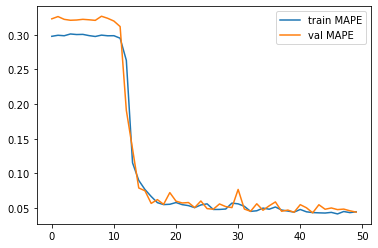

In [18]:
x_axis = np.arange(50)
plt.plot(x_axis, Train_MAPE_list[10:60], label='train MAPE')
plt.plot(x_axis, Valid_MAPE_list[10:60], label='val MAPE')
plt.legend()
plt.show()

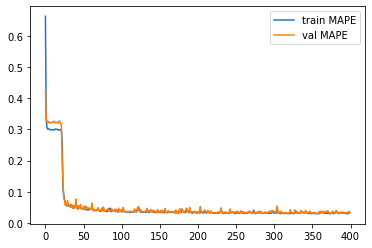

In [19]:
x_axis = np.arange(epoch+1)
plt.plot(x_axis, Train_MAPE_list[:], label='train MAPE')
plt.plot(x_axis, Valid_MAPE_list[:], label='val MAPE')
plt.legend()
plt.show()

In [20]:
## test performance on the test set and report final performance
X_test_tensor =  torch.tensor(x_test).float()
y_test_pred = model(X_test_tensor).float()[:,-1,:].reshape(-1).detach().numpy()
y_test_pred_inverse = y_test_pred*(max_test - min_test)+min_test
print("shape of test_y_pred:   ",y_test_pred_inverse.shape)
y_test_invesre = y_test*(max_test - min_test)+min_test


test_MAPE=sum(abs ((y_test_invesre - y_test_pred_inverse)/y_test_invesre))/len(y_test_invesre)
print(test_MAPE)

shape of test_y_pred:    (292,)
0.03513383471519304


In [21]:
BitCoin[1158:1338]['Date']

326    Dec 07 2020
325    Dec 08 2020
324    Dec 09 2020
323    Dec 10 2020
322    Dec 11 2020
          ...     
151    May 31 2021
150    Jun 01 2021
149    Jun 02 2021
148    Jun 03 2021
147    Jun 04 2021
Name: Date, Length: 180, dtype: object

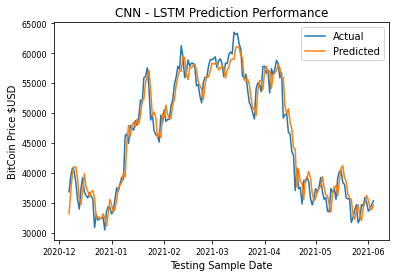

In [22]:
BitCoin['Date']=pd.to_datetime(BitCoin['Date'])
date = np.array(BitCoin[1158:1338]['Date'])
x_axis = date
plt.plot(x_axis, y_test_invesre[:180], label='Actual')
plt.plot(x_axis, y_test_pred_inverse[:180], label='Predicted')
plt.tick_params(axis = 'x', labelsize = 8)
plt.tick_params(axis = 'y', labelsize = 8)
plt.xlabel('Testing Sample Date')
plt.ylabel('BitCoin Price $USD')
plt.title("CNN - LSTM Prediction Performance")
plt.legend()
plt.show()